# Basic Machine Learning for Predicting Thunderstorm Rotation

This module uses basic ML models &ndash; linear regression, logistic regression, decision trees, and random forests &ndash; to predict future rotation in numerically simulated thunderstorms from the National Center for Atmospheric Research (NCAR) convection-allowing ensemble (Schwartz *et al.* 2015).

# References

This notebook refers to a few publications, listed below.

Schwartz, C., G. Romine, M. Weisman, R. Sobash, K. Fossell, K. Manning, and S. Trier, 2015: "A real-time convection-allowing ensemble prediction system initialized by mesoscale ensemble Kalman filter analyses." *Weather and Forecasting*, **30 (5)**, 1158-1181.

# Setup

To use this notebook, you will need Python 3.6 and the following packages.

 - scipy
 - TensorFlow
 - Keras
 - scikit-image
 - netCDF4
 - pyproj
 - scikit-learn
 - opencv-python
 - matplotlib
 - shapely
 - geopy
 - metpy
 - descartes

If you have Anaconda on a Linux or Mac, you can install these packages with the commands `pip install scipy`, `pip install tensorflow`, etc.

# Imports

The next cell imports all libraries that will be used by this notebook.  If the notebook crashes anywhere, it will probably be here.

In [19]:
%matplotlib inline
import copy
import numpy
import matplotlib.pyplot as pyplot
import sklearn.tree
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image
import utils

SEPARATOR_STRING = '\n\n' + '*' * 50 + '\n\n'
MINOR_SEPARATOR_STRING = '\n\n' + '-' * 50 + '\n\n'

MODULE2_DIR_NAME = '.'
SHORT_COURSE_DIR_NAME = '..'

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Find Input Files

The next cell finds input files for the training (2010-14), validation (2015), and testing (2016-17) periods.

In [3]:
training_file_names = utils.find_many_feature_files(
    first_date_string='20100101', last_date_string='20141231')

validation_file_names = utils.find_many_feature_files(
    first_date_string='20150101', last_date_string='20151231')

testing_file_names = utils.find_many_feature_files(
    first_date_string='20160101', last_date_string='20171231')

# Read Data

The next cell reads training, validation, and testing data &ndash; and explores the contents of one file.

In [4]:
(training_metadata_table, training_predictor_table_denorm,
 training_target_table
) = utils.read_many_feature_files(training_file_names)
print(MINOR_SEPARATOR_STRING)

(validation_metadata_table, validation_predictor_table_denorm,
 validation_target_table
) = utils.read_many_feature_files(validation_file_names)
print(MINOR_SEPARATOR_STRING)

(testing_metadata_table, testing_predictor_table_denorm,
 testing_target_table
) = utils.read_many_feature_files(testing_file_names)
print(MINOR_SEPARATOR_STRING)

print('Variables in metadata are as follows:\n{0:s}'.format(
    str(list(training_metadata_table))
))

print('\nPredictor variables are as follows:\n{0:s}'.format(
    str(list(training_predictor_table_denorm))
))

print('\nTarget variable is as follows:\n{0:s}'.format(
    str(list(training_target_table))
))

first_predictor_name = list(training_predictor_table_denorm)[0]
these_predictor_values = (
    training_predictor_table_denorm[first_predictor_name].values[:10]
)

message_string = (
    '\nValues of predictor variable "{0:s}" for the first training '
    'examples:\n{1:s}'
).format(first_predictor_name, str(these_predictor_values))
print(message_string)

target_name = list(training_target_table)[0]
these_target_values = training_target_table[target_name].values[:10]

message_string = (
    '\nValues of target variable for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110425-0000.csv"...
Reading data from: 



--------------------------------------------------


Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160224-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160323-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160401-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160415-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160429-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160505-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160511-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20160522-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_

# Normalization

The next cell does the following.

 - Finds normalization parameters (mean and standard deviation) for each predictor variable, based only on training data.
 - Normalizes training, validation, and testing data &ndash; using normalization parameters found for training data.  In this case "normalization" means transforming to $z$-scores.
 - Ensures that denormalized values = original values.

In [5]:
predictor_names = list(training_predictor_table_denorm)
these_predictor_values = (
    training_predictor_table_denorm[predictor_names[0]].values[:10]
)

message_string = (
    'Original values of "{0:s}" for the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

training_predictor_table, normalization_dict = utils.normalize_predictors(
    predictor_table=copy.deepcopy(training_predictor_table_denorm)
)

these_predictor_values = (
    training_predictor_table[predictor_names[0]].values[:10]
)

message_string = (
    '\nNormalized values of "{0:s}" for the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

training_predictor_table_denorm = utils.denormalize_predictors(
    predictor_table=copy.deepcopy(training_predictor_table),
    normalization_dict=normalization_dict
)

these_predictor_values = (
    training_predictor_table_denorm[predictor_names[0]].values[:10]
)

message_string = (
    '\n*De*normalized values (should equal original values) of "{0:s}" for '
    'the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

validation_predictor_table, _ = utils.normalize_predictors(
    predictor_table=copy.deepcopy(validation_predictor_table_denorm),
    normalization_dict=normalization_dict)

testing_predictor_table, _ = utils.normalize_predictors(
    predictor_table=copy.deepcopy(testing_predictor_table_denorm),
    normalization_dict=normalization_dict)

Original values of "REFL_COM_mean" for the first training examples:
[42.71822 47.09285 45.53852 44.30976 44.64383 44.33831 45.73259 43.69113
 45.3804  47.31104]

Normalized values of "REFL_COM_mean" for the first training examples:
[-1.03619508  0.06182963 -0.32830456 -0.63672124 -0.55287024 -0.62955524
 -0.27959332 -0.79199632 -0.36799241  0.11659495]

*De*normalized values (should equal original values) of "REFL_COM_mean" for the first training examples:
[42.71822 47.09285 45.53852 44.30976 44.64383 44.33831 45.73259 43.69113
 45.3804  47.31104]


# Linear Regression

In [9]:
plain_linear_model_object = utils.setup_linear_regression(
    lambda1=0., lambda2=0.)

utils.train_linear_regression(
    model_object=plain_linear_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = plain_linear_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = plain_linear_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

Training MAE (mean absolute error) = 7.714e-04 s^-1
Training MSE (mean squared error) = 1.112e-06 s^-2
Training bias (mean signed error) = 1.817e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.315
Training MSE skill score (improvement over climatology) = 0.521


--------------------------------------------------


Validation MAE (mean absolute error) = 7.505e-04 s^-1
Validation MSE (mean squared error) = 1.048e-06 s^-2
Validation bias (mean signed error) = -9.007e-07 s^-1
Validation MAE skill score (improvement over climatology) = 0.316
Validation MSE skill score (improvement over climatology) = 0.540


/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:520: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


# Linear Regression: Plotting Coefficients

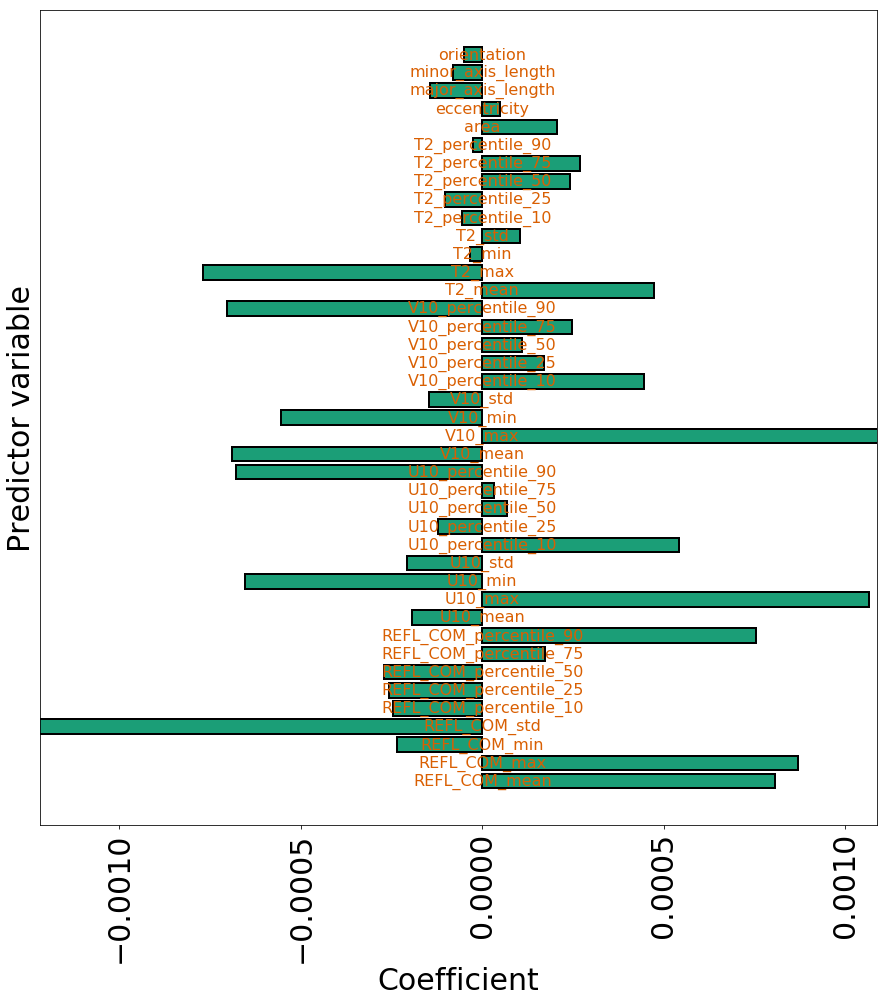

In [10]:
utils.plot_model_coefficients(
    model_object=plain_linear_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Linear Regression with Ridge Penalty ("Ridge Regression")

In [11]:
ridge_model_object = utils.setup_linear_regression(
    lambda1=0., lambda2=1.)

utils.train_linear_regression(
    model_object=ridge_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = ridge_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = ridge_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

Training MAE (mean absolute error) = 7.714e-04 s^-1
Training MSE (mean squared error) = 1.112e-06 s^-2
Training bias (mean signed error) = 2.544e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.315
Training MSE skill score (improvement over climatology) = 0.521


--------------------------------------------------


Validation MAE (mean absolute error) = 7.505e-04 s^-1
Validation MSE (mean squared error) = 1.049e-06 s^-2
Validation bias (mean signed error) = -8.899e-07 s^-1
Validation MAE skill score (improvement over climatology) = 0.316
Validation MSE skill score (improvement over climatology) = 0.540


/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:520: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


# "Ridge Regression": Plotting Coefficients

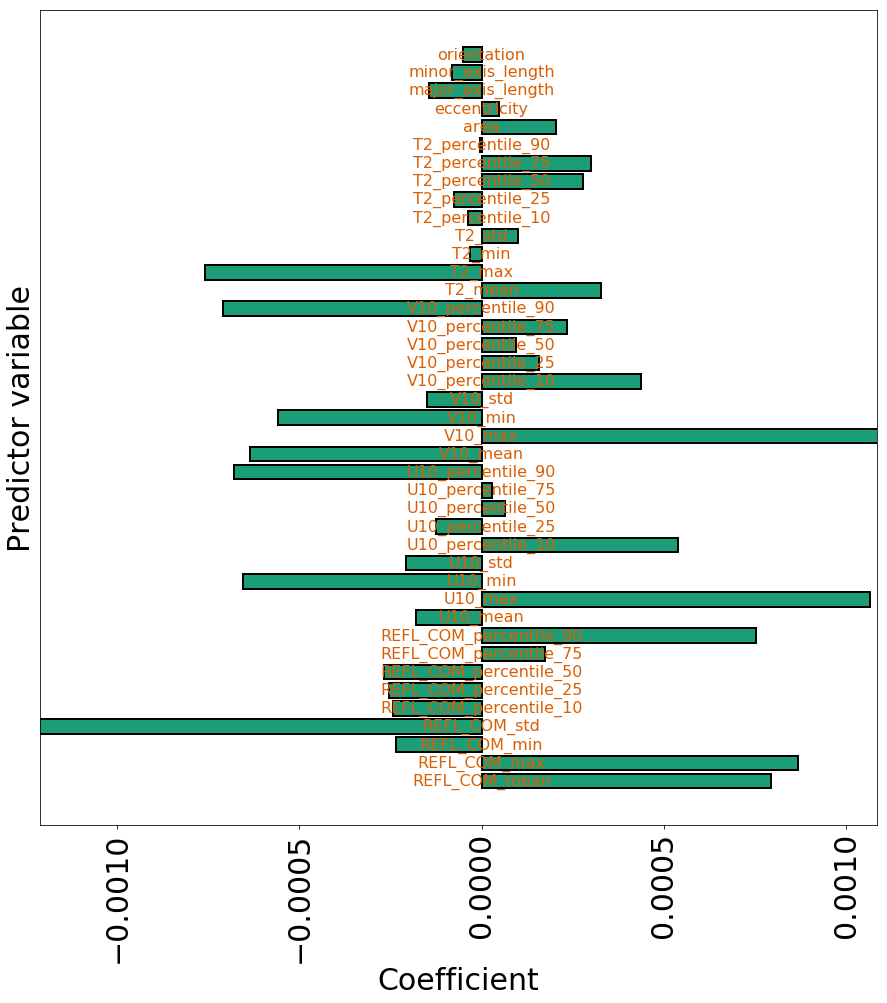

In [12]:
utils.plot_model_coefficients(
    model_object=ridge_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Linear Regression with Lasso Penalty ("Lasso Regression")

In [13]:
lasso_model_object = utils.setup_linear_regression(
    lambda1=1e-6, lambda2=0.)

utils.train_linear_regression(
    model_object=lasso_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = lasso_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = lasso_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:520: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training MAE (mean absolute error) = 7.726e-04 s^-1
Training MSE (mean squared error) = 1.116e-06 s^-2
Training bias (mean signed error) = 3.198e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.314
Training MSE skill score (improvement over climatology) = 0.520


--------------------------------------------------


Validation MAE (mean absolute error) = 7.514e-04 s^-1
Validation MSE (mean squared error) = 1.051e-06 s^-2
Validation bias (mean signed error) = -5.108e-07 s^-1
Validation MAE skill score (improvement over climatology) = 0.315
Validation MSE skill score (improvement over climatology) = 0.539


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


# "Lasso Regression": Plotting Coefficients

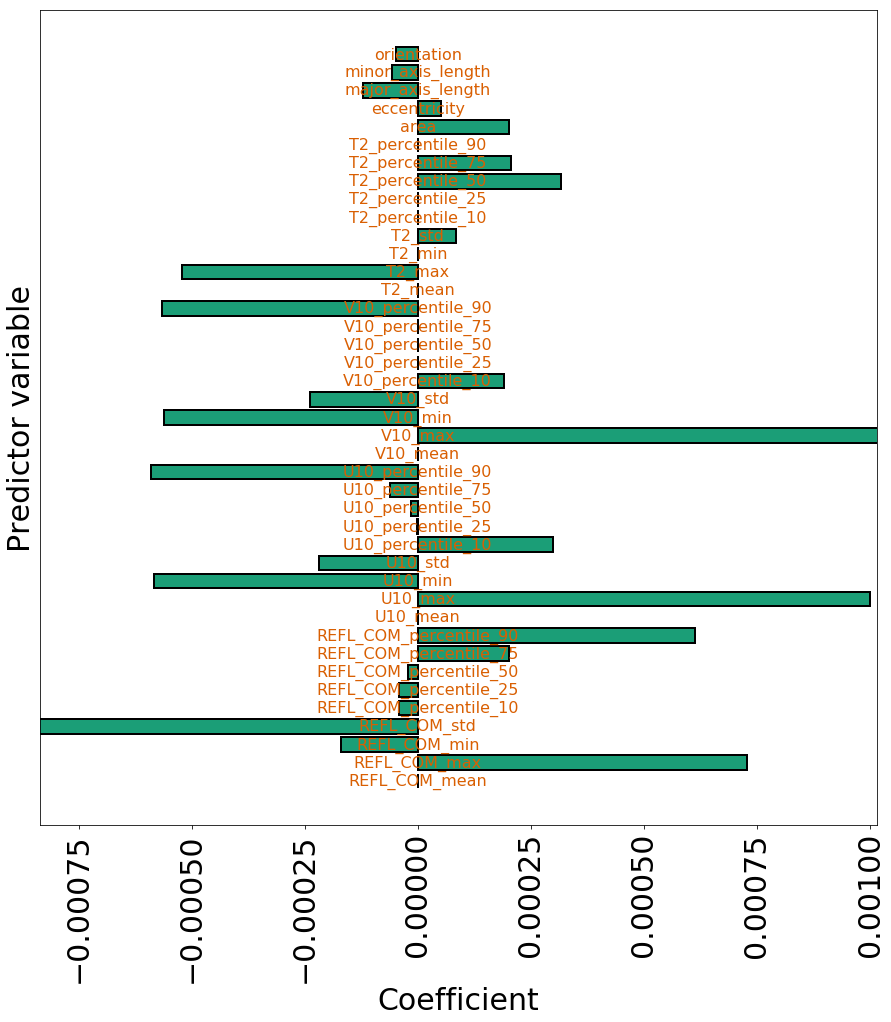

In [14]:
utils.plot_model_coefficients(
    model_object=lasso_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Linear Regression with Elastic-net Penalty ("Elastic-net Regression")

In [15]:
elastic_net_model_object = utils.setup_linear_regression(
    lambda1=1e-6, lambda2=1.)

utils.train_linear_regression(
    model_object=elastic_net_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = elastic_net_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = elastic_net_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:520: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training MAE (mean absolute error) = 8.093e-04 s^-1
Training MSE (mean squared error) = 1.245e-06 s^-2
Training bias (mean signed error) = 3.365e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.282
Training MSE skill score (improvement over climatology) = 0.464


--------------------------------------------------


Validation MAE (mean absolute error) = 7.880e-04 s^-1
Validation MSE (mean squared error) = 1.182e-06 s^-2
Validation bias (mean signed error) = 6.692e-06 s^-1
Validation MAE skill score (improvement over climatology) = 0.282
Validation MSE skill score (improvement over climatology) = 0.481


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


# "Elastic-net Regression": Plotting Coefficients

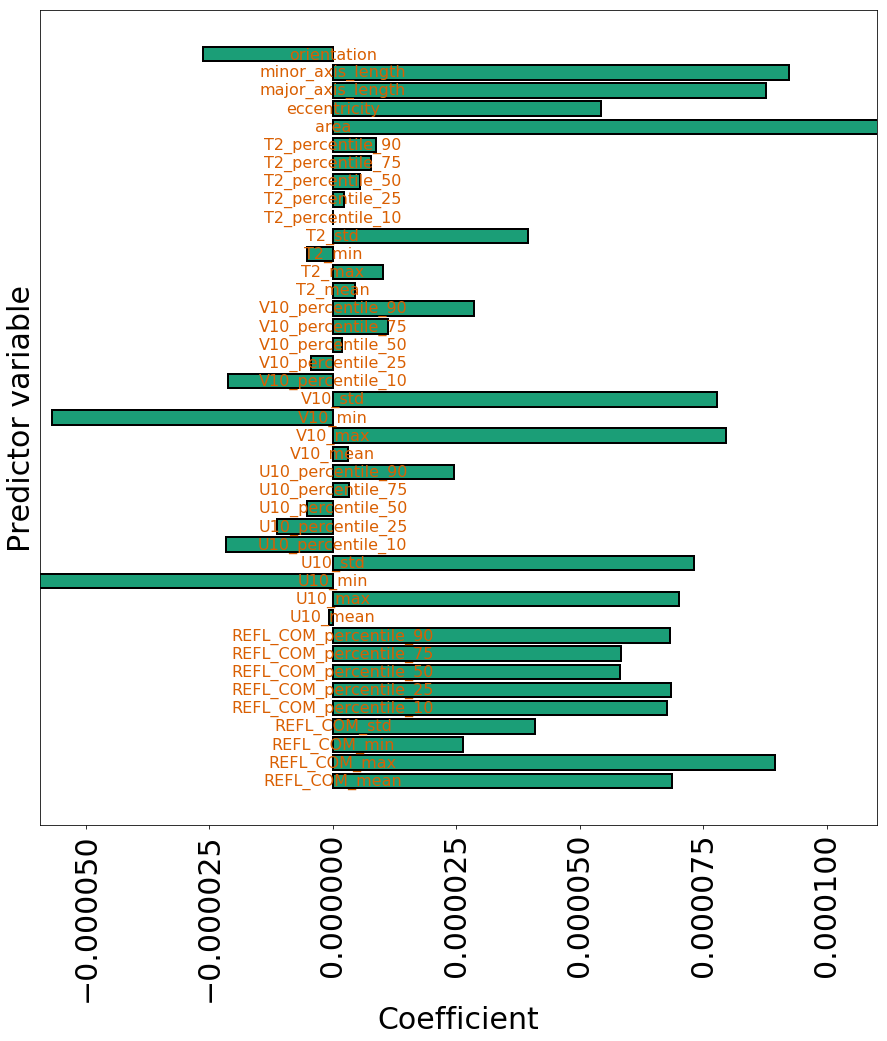

In [16]:
utils.plot_model_coefficients(
    model_object=elastic_net_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Hyperparameter Experiment: Finding Best Elastic Net

In [14]:
lambda1_values = numpy.logspace(-8, -4, num=9)
lambda2_values = numpy.logspace(-8, -4, num=9)

num_lambda1 = len(lambda1_values)
num_lambda2 = len(lambda2_values)

validation_mae_matrix_s01 = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)
validation_mse_matrix_s02 = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)
validation_mae_skill_matrix = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)
validation_mse_skill_matrix = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)

mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

for i in range(num_lambda1):
    for j in range(num_lambda2):
        this_message_string = (
            'Training model with lasso coeff = 10^{0:.1f}, ridge coeff = '
            '10^{1:.1f}...'
        ).format(
            numpy.log10(lambda1_values[i]), numpy.log10(lambda2_values[j])
        )

        print(this_message_string)

        this_model_object = utils.setup_linear_regression(
            lambda1=lambda1_values[i], lambda2=lambda2_values[j]
        )

        utils.train_linear_regression(
            model_object=this_model_object,
            training_predictor_table=training_predictor_table,
            training_target_table=training_target_table)

        these_validation_predictions = this_model_object.predict(
            validation_predictor_table.as_matrix()
        )

        this_evaluation_dict = utils.evaluate_regression(
            target_values=validation_target_table[utils.TARGET_NAME].values,
            predicted_target_values=these_validation_predictions,
            mean_training_target_value=mean_training_target_value,
            verbose=False)

        validation_mae_matrix_s01[i, j] = this_evaluation_dict[
            utils.MAE_KEY]
        validation_mse_matrix_s02[i, j] = this_evaluation_dict[
            utils.MSE_KEY]
        validation_mae_skill_matrix[i, j] = this_evaluation_dict[
            utils.MAE_SKILL_SCORE_KEY]
        validation_mse_skill_matrix[i, j] = this_evaluation_dict[
            utils.MSE_SKILL_SCORE_KEY]

Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-8.0...


/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-7.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-7.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-6.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-6.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-5.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-5.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-4.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-4.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-8.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-7.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-7.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-6.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-6.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-5.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-5.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-4.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-4.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-7.0, ridge coeff = 10^-8.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-7.0, ridge coeff = 10^-7.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-7.0, ridge coeff = 10^-7.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-7.0, ridge coeff = 10^-6.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-7.0, ridge coeff = 10^-6.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-7.0, ridge coeff = 10^-5.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-7.0, ridge coeff = 10^-5.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-7.0, ridge coeff = 10^-4.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-7.0, ridge coeff = 10^-4.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-6.5, ridge coeff = 10^-8.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-6.5, ridge coeff = 10^-7.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-6.5, ridge coeff = 10^-7.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-6.5, ridge coeff = 10^-6.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-6.5, ridge coeff = 10^-6.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-6.5, ridge coeff = 10^-5.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-6.5, ridge coeff = 10^-5.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-6.5, ridge coeff = 10^-4.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-6.5, ridge coeff = 10^-4.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-6.0, ridge coeff = 10^-8.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-6.0, ridge coeff = 10^-7.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-6.0, ridge coeff = 10^-7.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-6.0, ridge coeff = 10^-6.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-6.0, ridge coeff = 10^-6.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-6.0, ridge coeff = 10^-5.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-6.0, ridge coeff = 10^-5.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-6.0, ridge coeff = 10^-4.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-6.0, ridge coeff = 10^-4.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-5.5, ridge coeff = 10^-8.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-5.5, ridge coeff = 10^-7.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-5.5, ridge coeff = 10^-7.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-5.5, ridge coeff = 10^-6.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-5.5, ridge coeff = 10^-6.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-5.5, ridge coeff = 10^-5.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-5.5, ridge coeff = 10^-5.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-5.5, ridge coeff = 10^-4.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-5.5, ridge coeff = 10^-4.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-5.0, ridge coeff = 10^-8.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-5.0, ridge coeff = 10^-7.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-5.0, ridge coeff = 10^-7.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-5.0, ridge coeff = 10^-6.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-5.0, ridge coeff = 10^-6.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-5.0, ridge coeff = 10^-5.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-5.0, ridge coeff = 10^-5.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-5.0, ridge coeff = 10^-4.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-5.0, ridge coeff = 10^-4.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-4.5, ridge coeff = 10^-8.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-4.5, ridge coeff = 10^-7.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-4.5, ridge coeff = 10^-7.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-4.5, ridge coeff = 10^-6.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-4.5, ridge coeff = 10^-6.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-4.5, ridge coeff = 10^-5.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-4.5, ridge coeff = 10^-5.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-4.5, ridge coeff = 10^-4.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-4.5, ridge coeff = 10^-4.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-4.0, ridge coeff = 10^-8.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-4.0, ridge coeff = 10^-7.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-4.0, ridge coeff = 10^-7.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-4.0, ridge coeff = 10^-6.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-4.0, ridge coeff = 10^-6.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-4.0, ridge coeff = 10^-5.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-4.0, ridge coeff = 10^-5.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-4.0, ridge coeff = 10^-4.5...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training model with lasso coeff = 10^-4.0, ridge coeff = 10^-4.0...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


# Hyperparameter Experiment: Plotting Results

Text(0.5, 1.0, 'MSE (mean squared error) skill score on validation data')

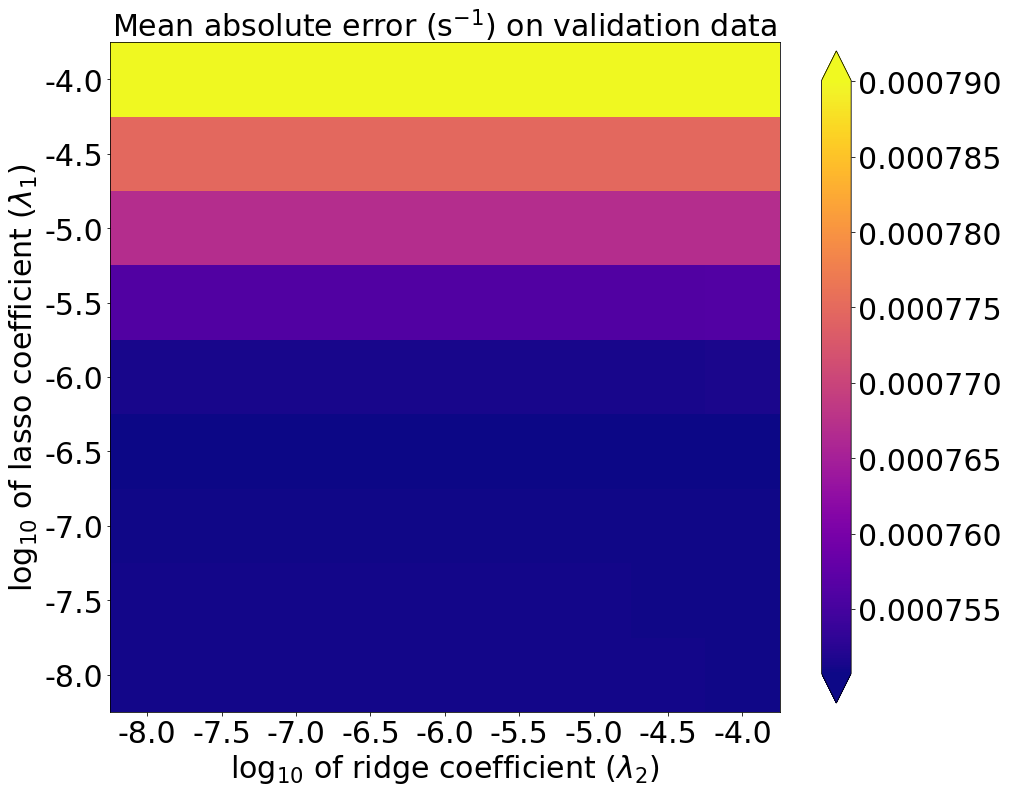

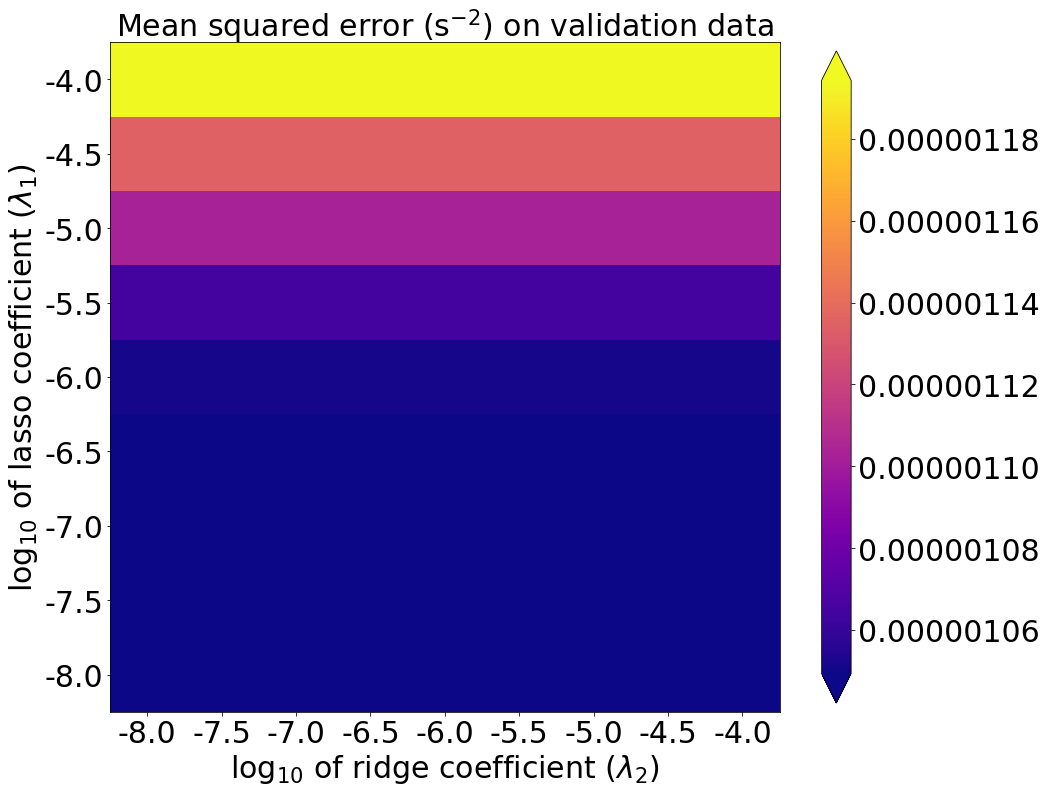

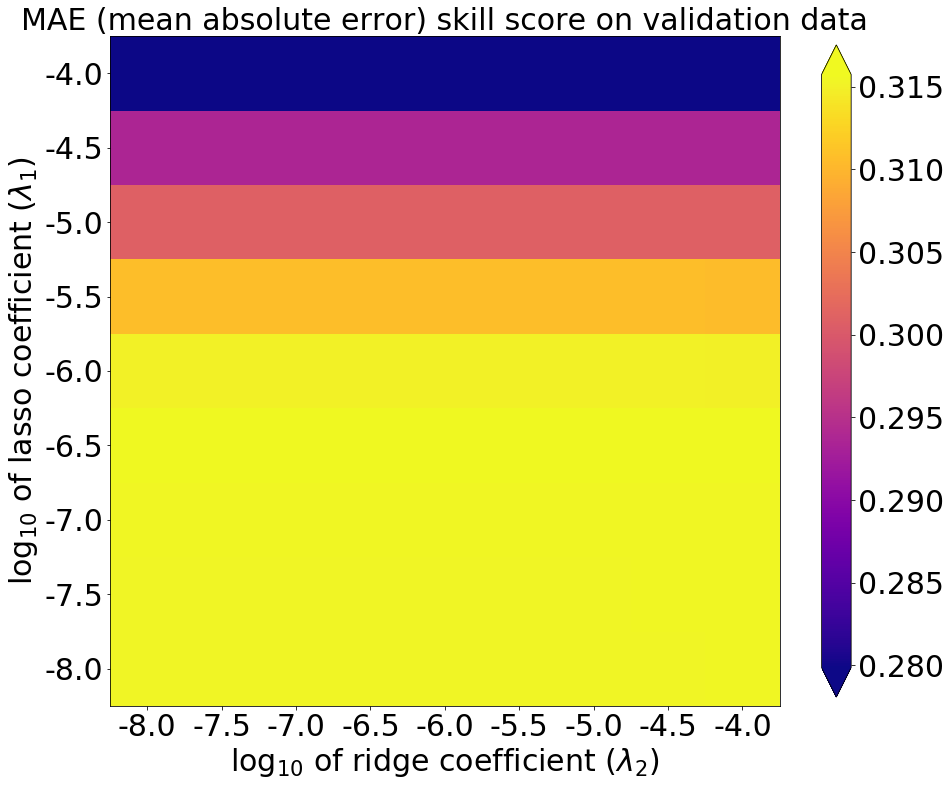

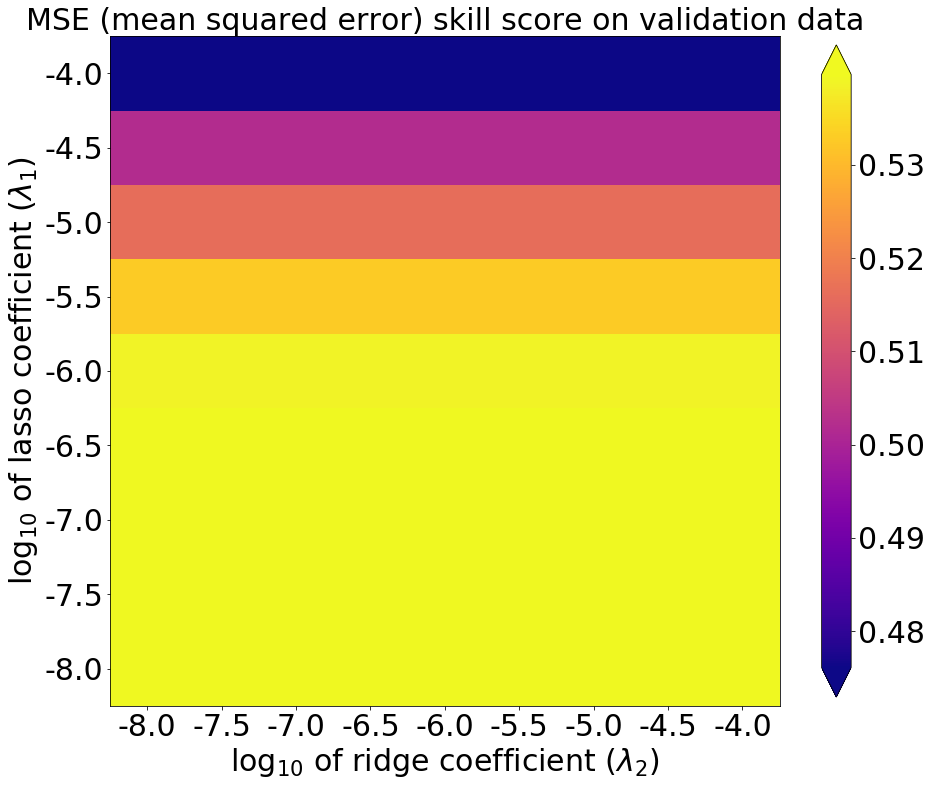

In [16]:
utils.plot_scores_2d(
    score_matrix=validation_mae_matrix_s01,
    min_colour_value=numpy.percentile(validation_mae_matrix_s01, 1.),
    max_colour_value=numpy.percentile(validation_mae_matrix_s01, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'Mean absolute error (s$^{-1}$) on validation data')

utils.plot_scores_2d(
    score_matrix=validation_mse_matrix_s02,
    min_colour_value=numpy.percentile(validation_mse_matrix_s02, 1.),
    max_colour_value=numpy.percentile(validation_mse_matrix_s02, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'Mean squared error (s$^{-2}$) on validation data')

utils.plot_scores_2d(
    score_matrix=validation_mae_skill_matrix,
    min_colour_value=numpy.percentile(validation_mae_skill_matrix, 1.),
    max_colour_value=numpy.percentile(validation_mae_skill_matrix, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'MAE (mean absolute error) skill score on validation data')

utils.plot_scores_2d(
    score_matrix=validation_mse_skill_matrix,
    min_colour_value=numpy.percentile(validation_mse_skill_matrix, 1.),
    max_colour_value=numpy.percentile(validation_mse_skill_matrix, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'MSE (mean squared error) skill score on validation data')

# Hyperparameter Experiment: Select Model

In [17]:
best_linear_index = numpy.argmax(numpy.ravel(validation_mae_skill_matrix))

best_lambda1_index, best_lambda2_index = numpy.unravel_index(
    best_linear_index, (len(lambda1_values), len(lambda2_values))
)

best_lambda1 = lambda1_values[best_lambda1_index]
best_lambda2 = lambda2_values[best_lambda2_index]
best_validation_maess = numpy.max(validation_mae_skill_matrix)

message_string = (
    'Best MAE skill score on validation data = {0:.3f} ... corresponding '
    'lasso coeff = 10^{1:.1f}, ridge coeff = 10^{2:.1f}'
).format(
    best_validation_maess, numpy.log10(best_lambda1),
    numpy.log10(best_lambda2)
)

print(message_string)

final_model_object = utils.setup_linear_regression(
    lambda1=best_lambda1, lambda2=best_lambda2)

utils.train_linear_regression(
    model_object=final_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

testing_predictions = final_model_object.predict(
    testing_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

this_evaluation_dict = utils.evaluate_regression(
    target_values=testing_target_table[utils.TARGET_NAME].values,
    predicted_target_values=testing_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='testing')

Best MAE skill score on validation data = 0.316 ... corresponding lasso coeff = 10^-6.5, ridge coeff = 10^-8.0


/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:512: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Testing MAE (mean absolute error) = 8.256e-04 s^-1
Testing MSE (mean squared error) = 1.412e-06 s^-2
Testing bias (mean signed error) = -8.974e-05 s^-1
Testing MAE skill score (improvement over climatology) = 0.339
Testing MSE skill score (improvement over climatology) = 0.555


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


# Binarization

The next cell does the following.

 - Finds binarization threshold for target variable (max future rotation), based only on training data.  This will be the 90$^{\textrm{th}}$ percentile over all training examples.
 - Binarizes target variable for training, validation, and testing data &ndash; using the threshold found for training data.  "Binarization" means transforming each value to a 0 or 1 (yes or no): 0 if $<$ threshold, 1 if $\ge$ threshold.

In [6]:
binarization_threshold = utils.get_binarization_threshold(
    csv_file_names=training_file_names, percentile_level=90.)
print(MINOR_SEPARATOR_STRING)

these_target_values = (
    training_target_table[utils.TARGET_NAME].values[:10]
)

message_string = (
    'Real-numbered target values for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

training_target_values = utils.binarize_target_values(
    target_values=training_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold)

training_target_table = training_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: training_target_values}
)

print('\nBinarization threshold = {0:.3e} s^-1'.format(
    binarization_threshold
))

these_target_values = (
    training_target_table[utils.TARGET_NAME].values[:10]
)

message_string = (
    '\nBinarized target values for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

validation_target_values = utils.binarize_target_values(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold)

validation_target_table = validation_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: validation_target_values}
)

testing_target_values = utils.binarize_target_values(
    target_values=testing_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold)

testing_target_table = testing_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: testing_target_values}
)

Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110425-0000.csv"...
Reading data from: 

# Logistic Regression

/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:825: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not

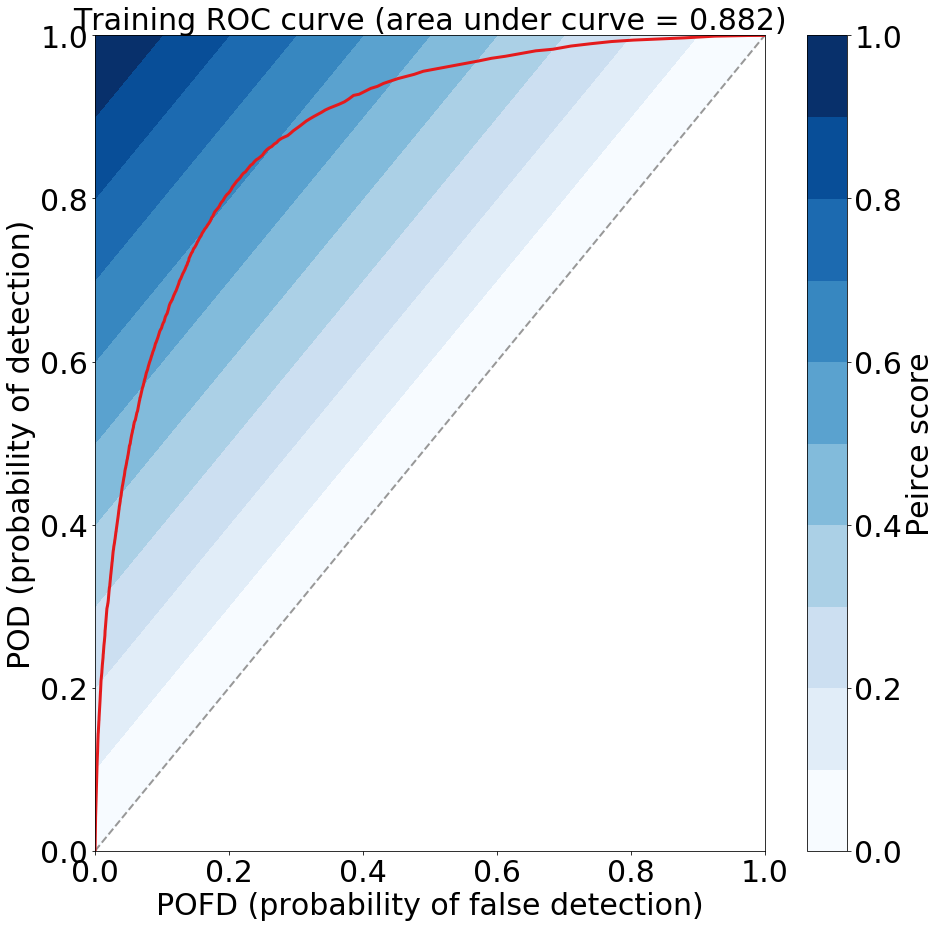

/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:226: RuntimeWarning: invalid value encountered in true_divide
  float(this_num_hits) / (this_num_hits + this_num_false_alarms)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:65: RuntimeWarning: divide by zero encountered in reciprocal
  return (success_ratio_array ** -1 + pod_array ** -1 - 1.) ** -1
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:78: RuntimeWarning: divide by zero encountered in true_divide
  return pod_array / success_ratio_array
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:78: RuntimeWarning: invalid value encountered in true_divide
  return pod_array

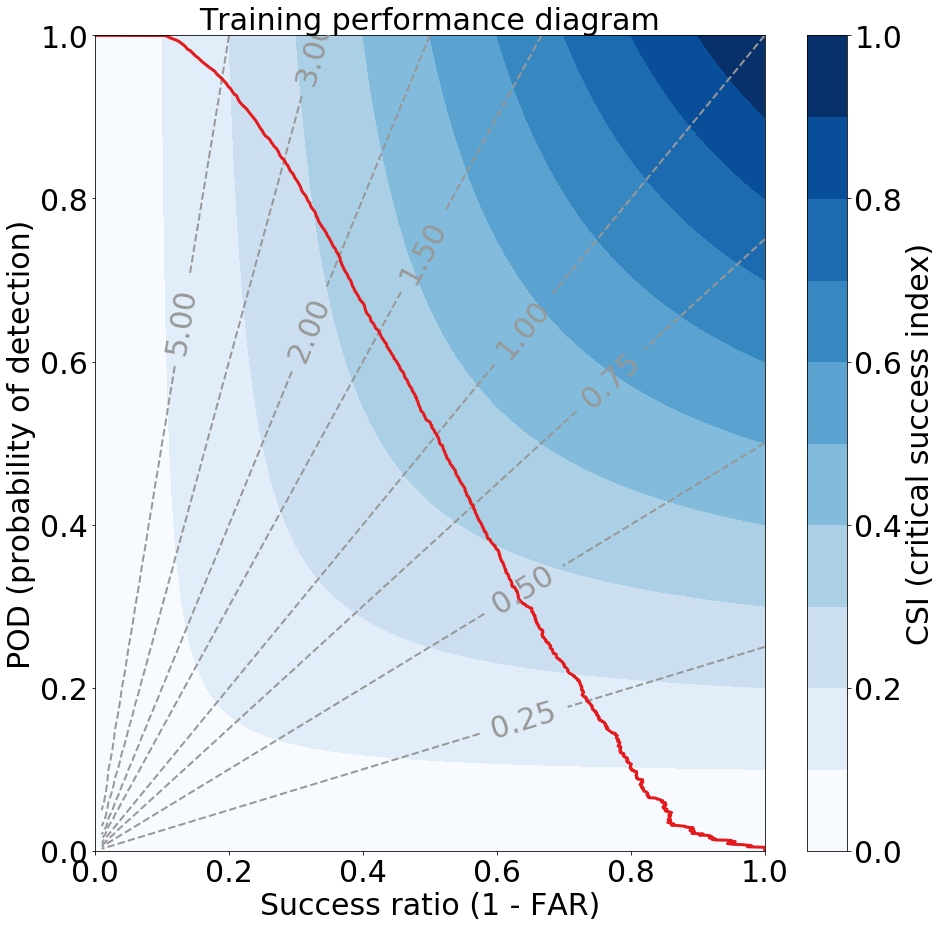

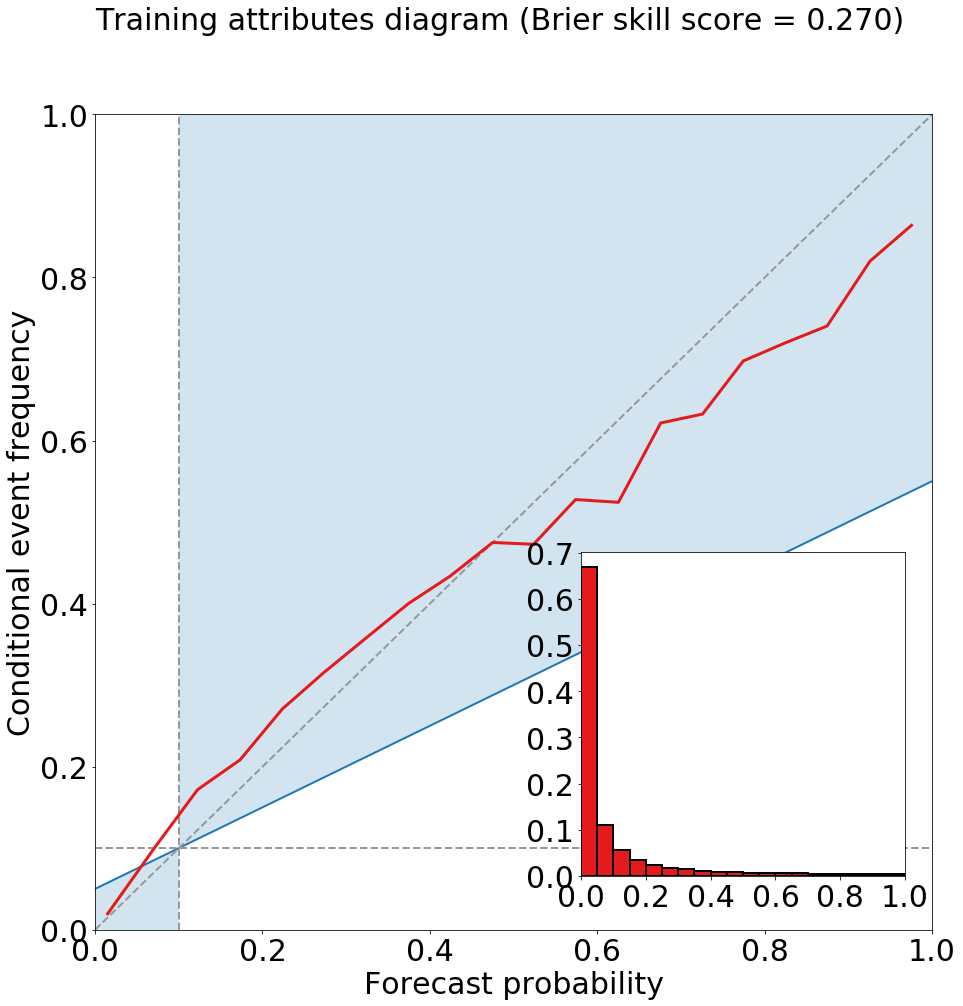

/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'axes'
  s)


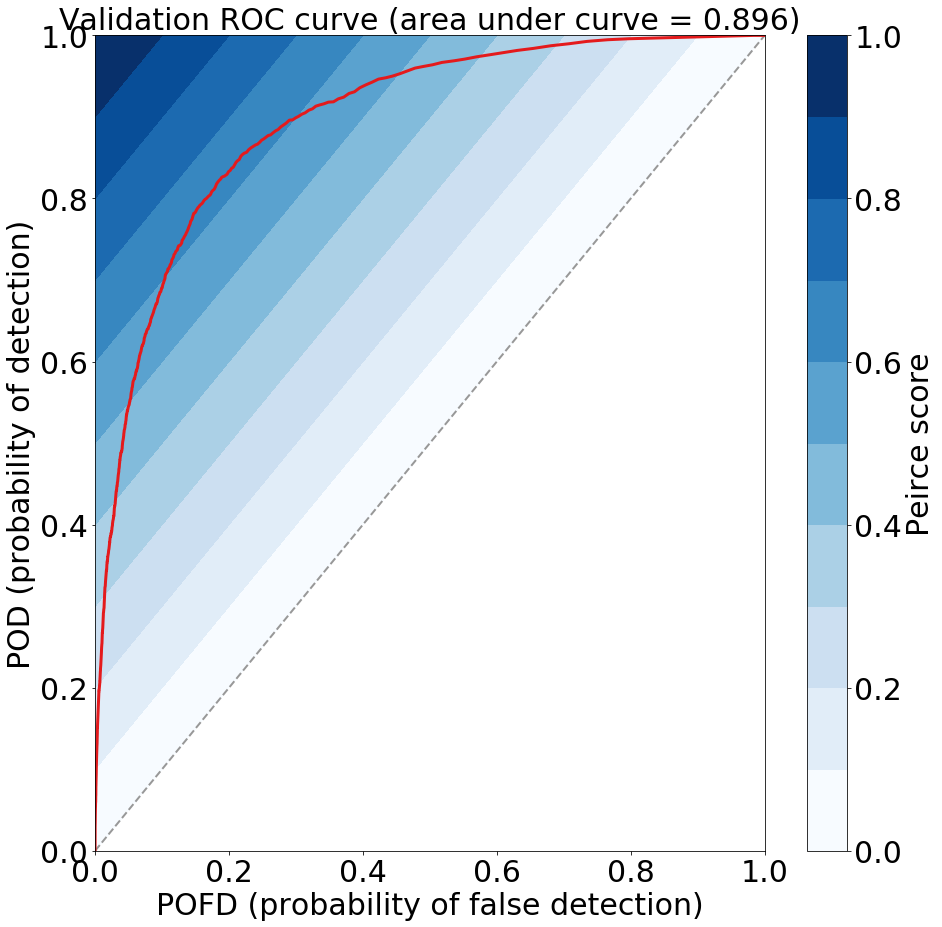

/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:226: RuntimeWarning: invalid value encountered in true_divide
  float(this_num_hits) / (this_num_hits + this_num_false_alarms)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:65: RuntimeWarning: divide by zero encountered in reciprocal
  return (success_ratio_array ** -1 + pod_array ** -1 - 1.) ** -1
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:78: RuntimeWarning: divide by zero encountered in true_divide
  return pod_array / success_ratio_array
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:78: RuntimeWarning: invalid value encountered in true_divide
  return pod_array

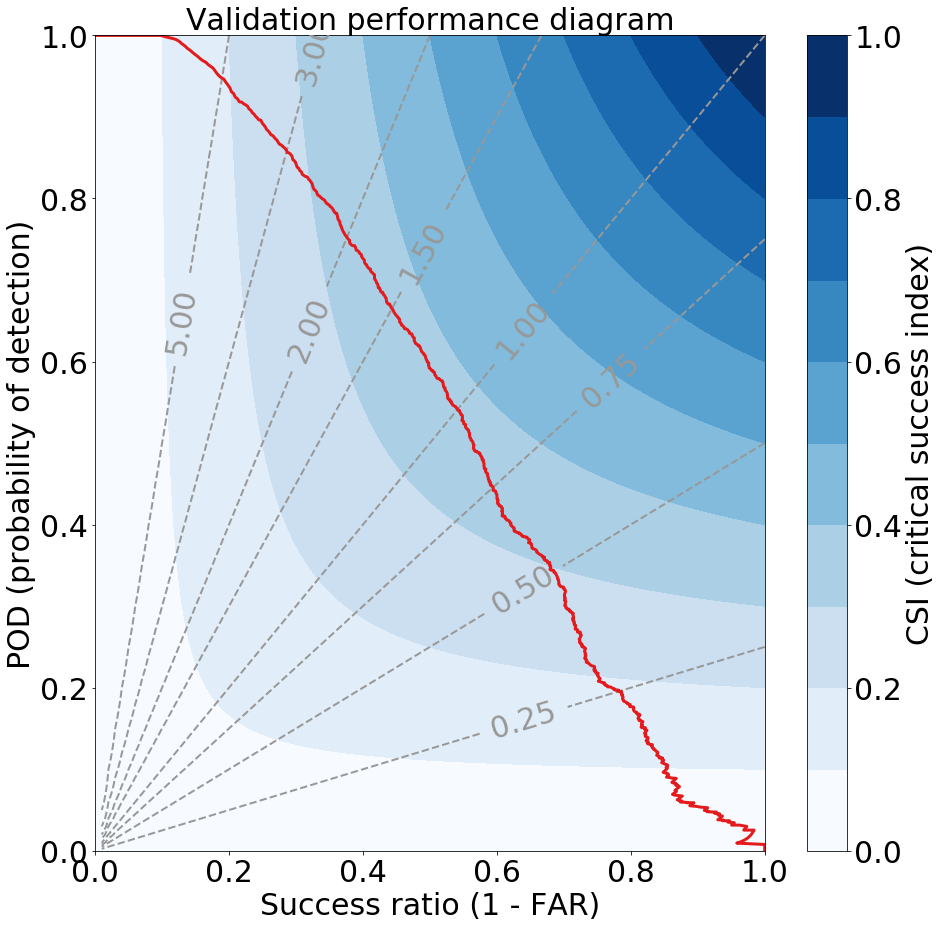

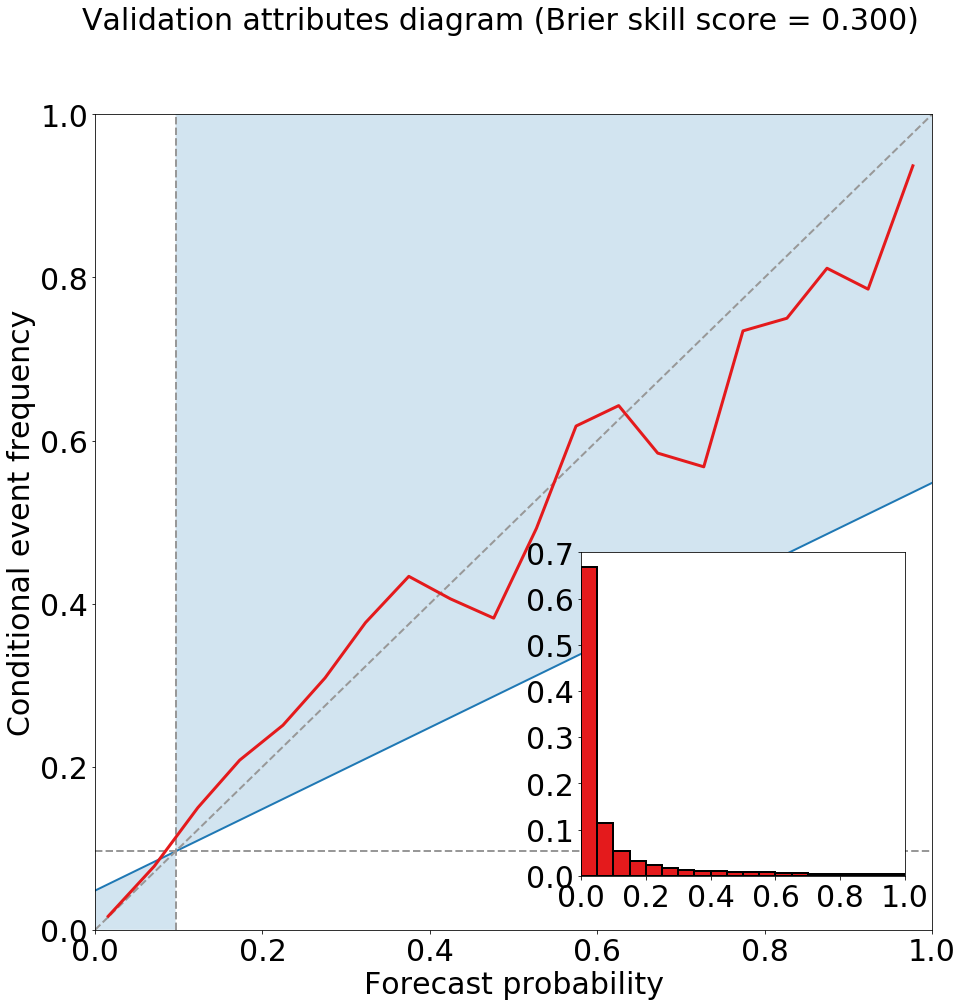

In [7]:
plain_log_model_object = utils.setup_logistic_regression(
    lambda1=0., lambda2=0.)

_ = utils.train_logistic_regression(
    model_object=plain_log_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_probabilities = plain_log_model_object.predict_proba(
    training_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

utils.eval_binary_classifn(
    observed_labels=training_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=training_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='training')

validation_probabilities = plain_log_model_object.predict_proba(
    validation_predictor_table.as_matrix()
)[:, 1]

utils.eval_binary_classifn(
    observed_labels=validation_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation')

# Logistic Regression: Plotting Coefficients

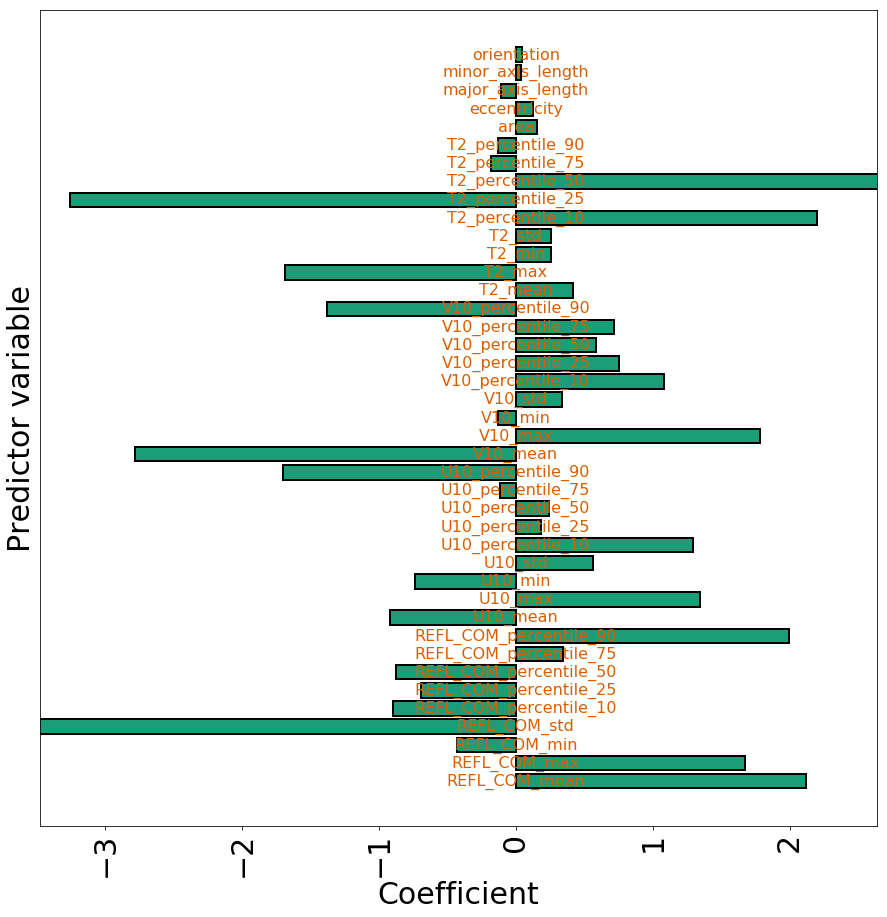

In [8]:
utils.plot_model_coefficients(
    model_object=plain_log_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Logistic Regression with Elastic Net

/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:825: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not

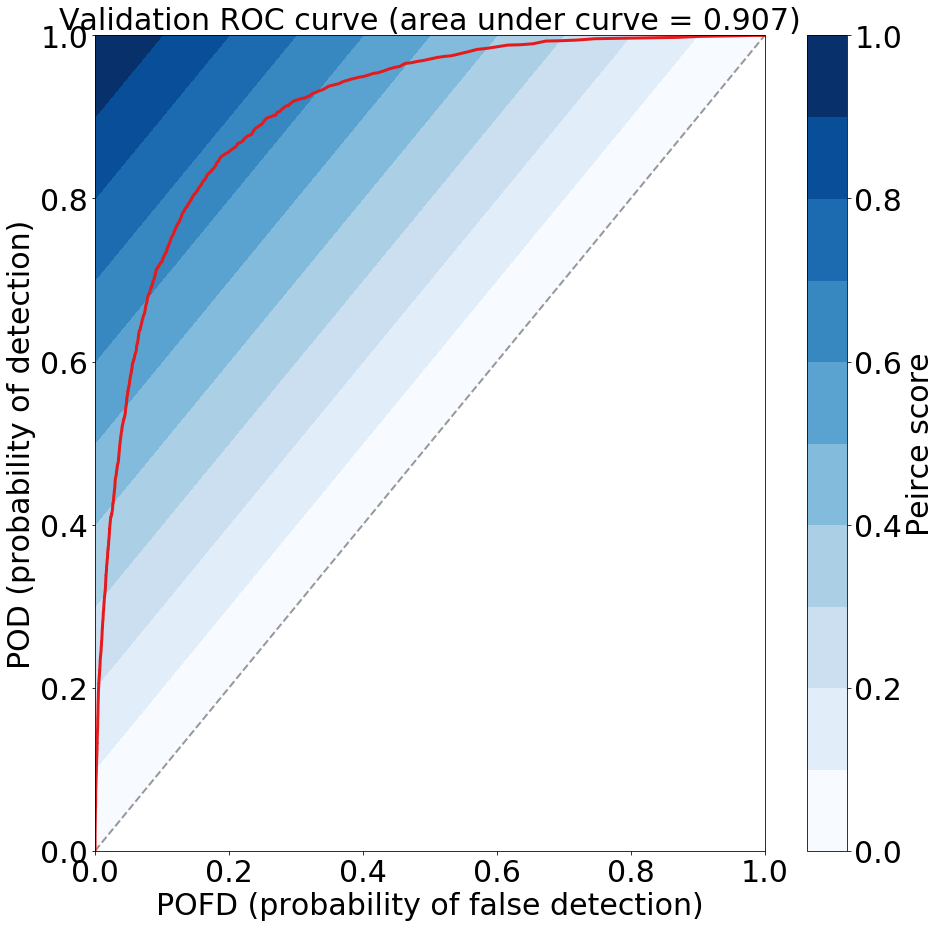

/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:226: RuntimeWarning: invalid value encountered in true_divide
  float(this_num_hits) / (this_num_hits + this_num_false_alarms)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:65: RuntimeWarning: divide by zero encountered in reciprocal
  return (success_ratio_array ** -1 + pod_array ** -1 - 1.) ** -1
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:78: RuntimeWarning: divide by zero encountered in true_divide
  return pod_array / success_ratio_array
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:78: RuntimeWarning: invalid value encountered in true_divide
  return pod_array

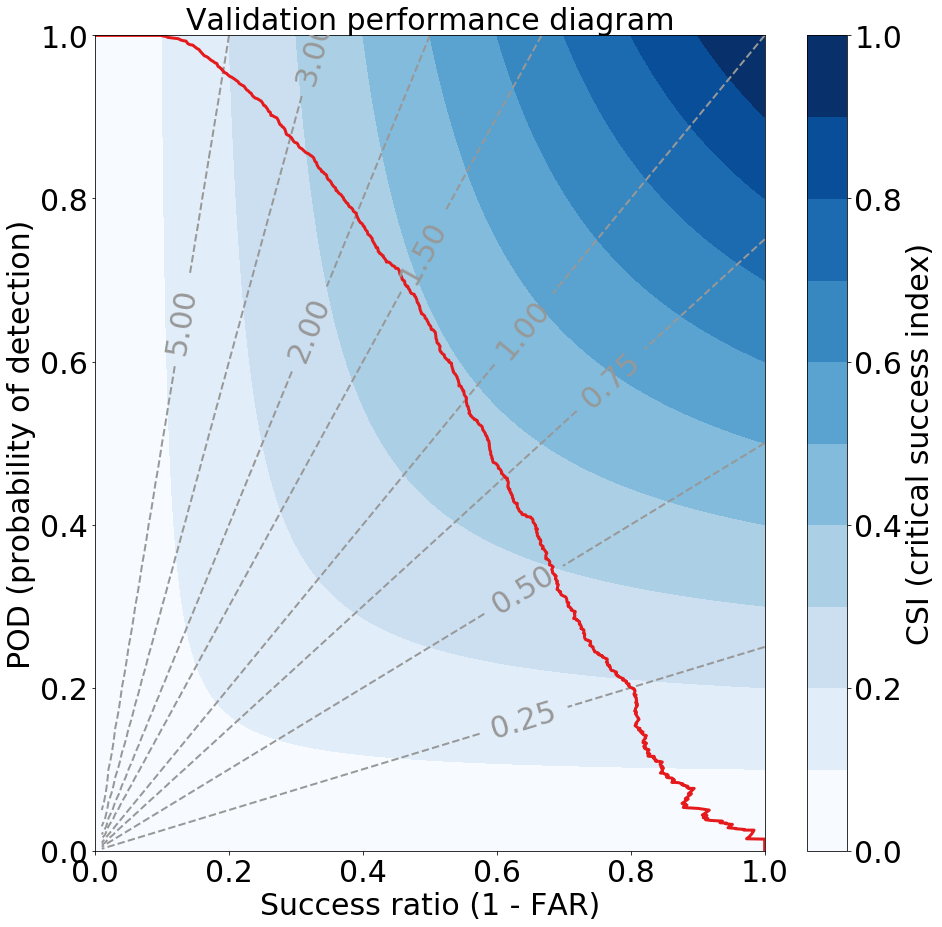

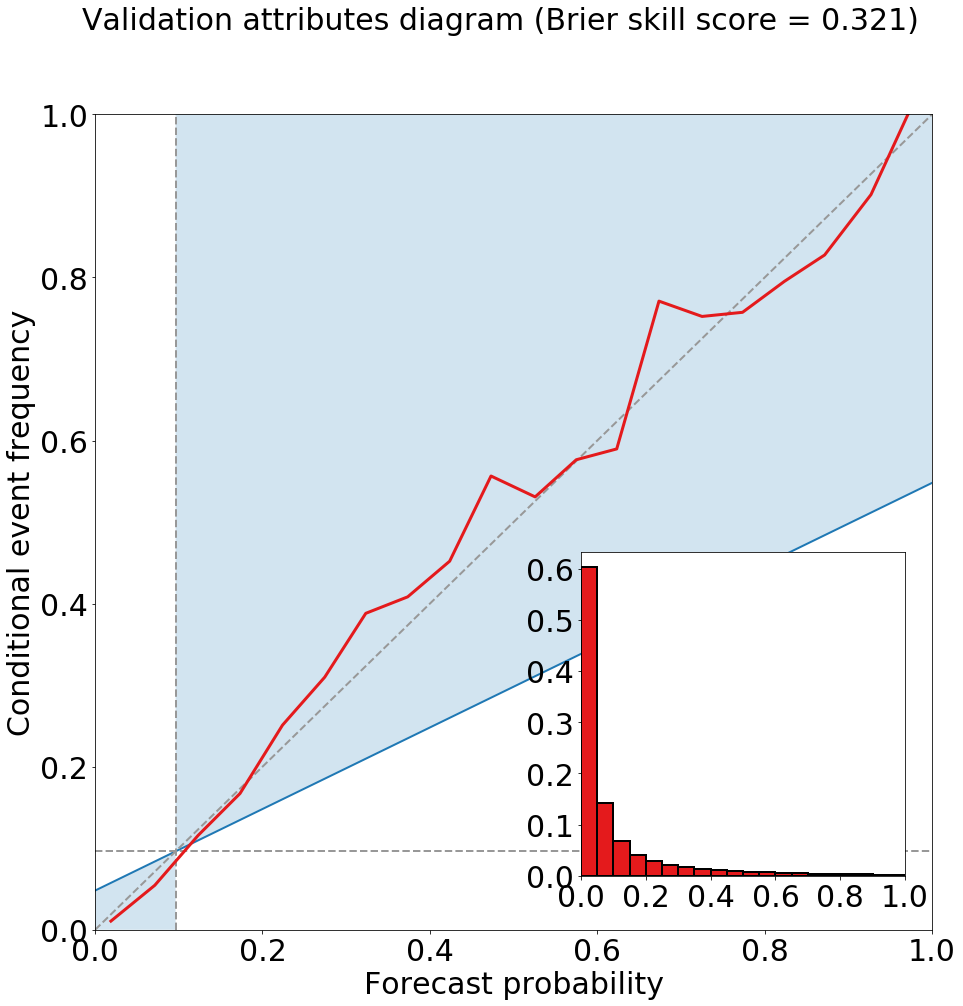

In [9]:
en_logistic_model_object = utils.setup_logistic_regression(
    lambda1=1e-3, lambda2=1e-3)

_ = utils.train_logistic_regression(
    model_object=en_logistic_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

validation_probabilities = en_logistic_model_object.predict_proba(
    validation_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

utils.eval_binary_classifn(
    observed_labels=validation_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation')

# Logistic Regression with Elastic Net: Coefficients

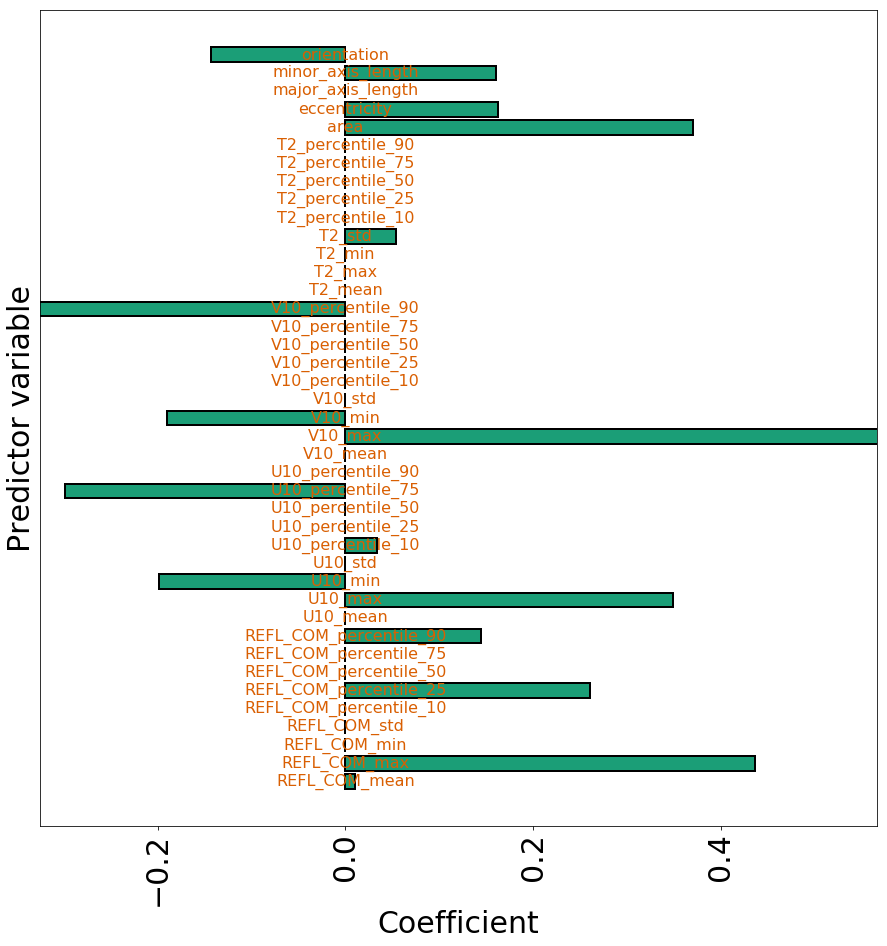

In [10]:
utils.plot_model_coefficients(
    model_object=en_logistic_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Decision Trees

/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:927: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'axes'
  s)


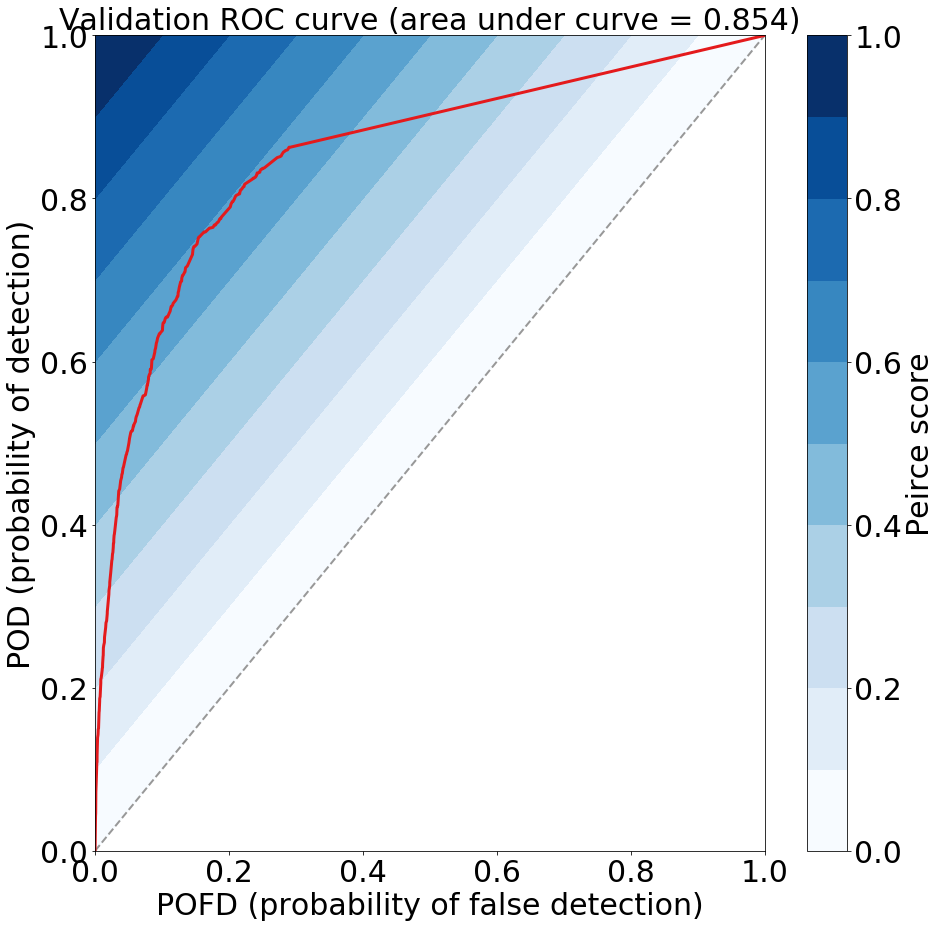

/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:65: RuntimeWarning: divide by zero encountered in reciprocal
  return (success_ratio_array ** -1 + pod_array ** -1 - 1.) ** -1
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:78: RuntimeWarning: divide by zero encountered in true_divide
  return pod_array / success_ratio_array
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:78: RuntimeWarning: invalid value encountered in true_divide
  return pod_array / success_ratio_array


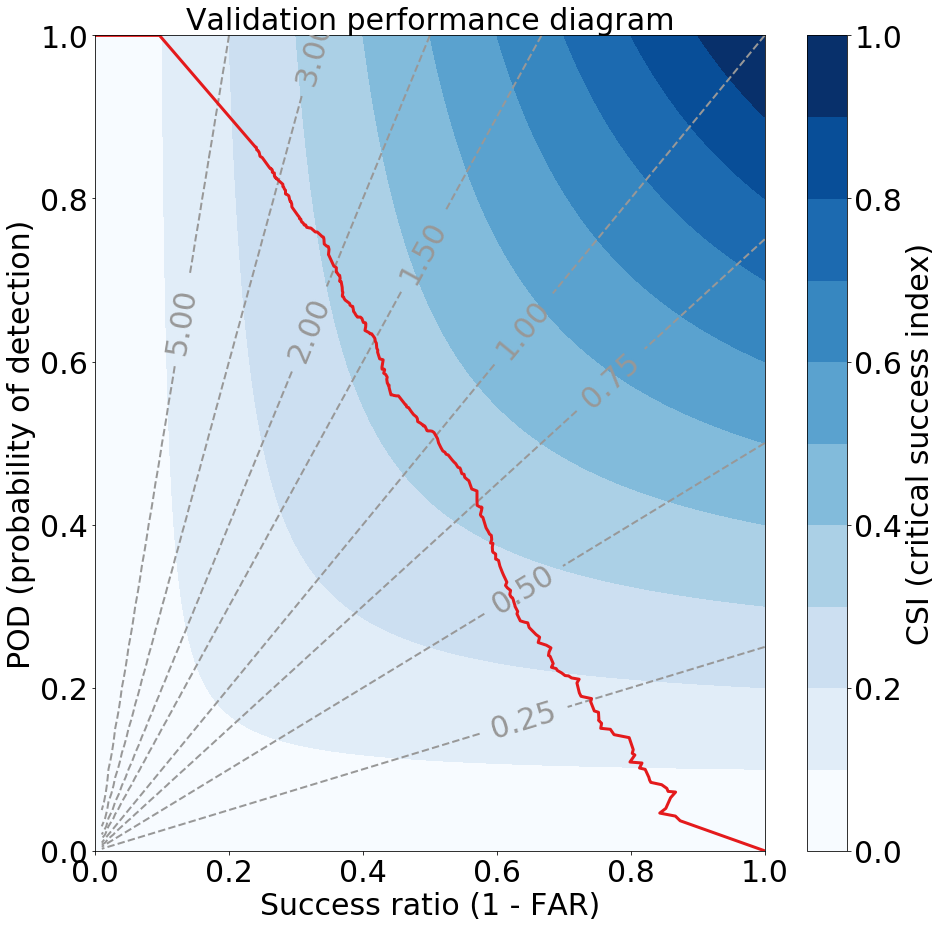

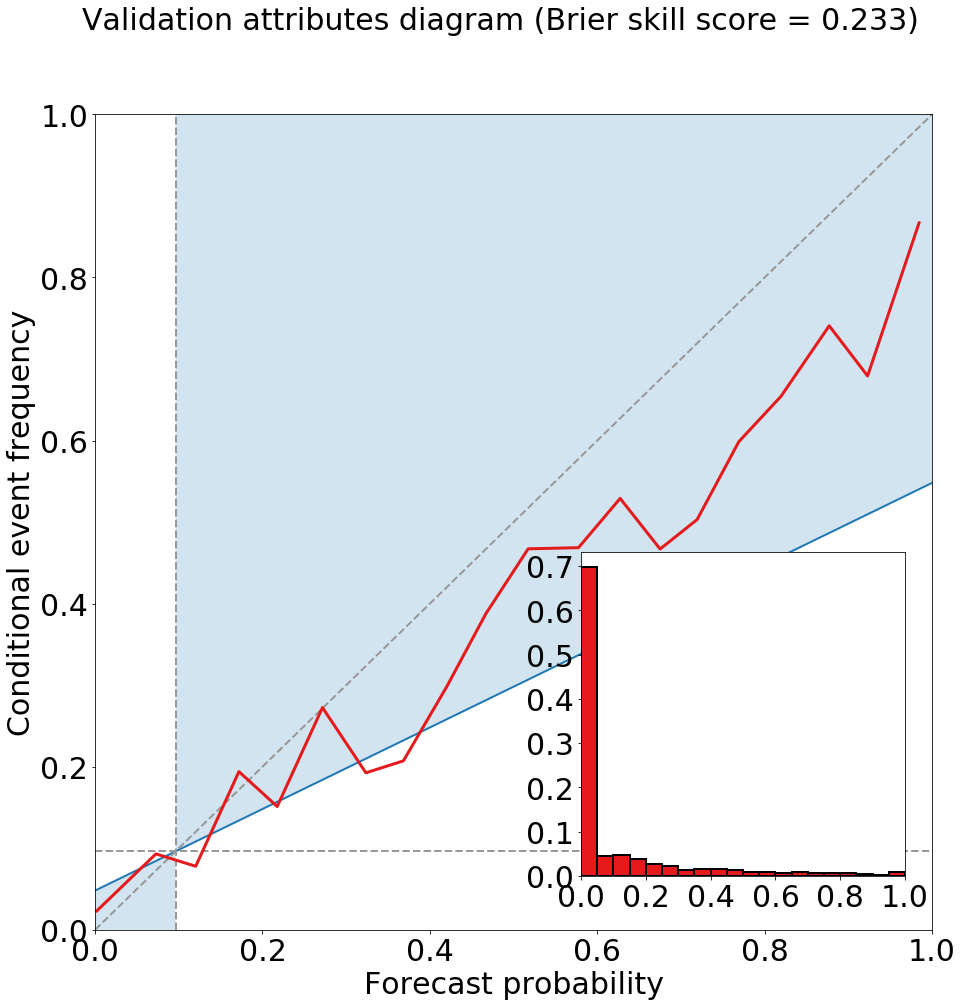

In [8]:
model_object = utils.setup_classification_tree()

_ = utils.train_classification_tree(
    model_object=model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

validation_probabilities = model_object.predict_proba(
    validation_predictor_table.as_matrix()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

utils.eval_binary_classifn(
    observed_labels=validation_target_table[
        utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation')

# Decision Tree: Visualization

This doesn't work.  Will probably just throw out.

In [20]:
def plot_decision_tree(model_object):
    """Plots decision tree.

    :param model_object: Trained decision tree (instance of
        `sklearn.tree.DecisionTreeClassifier`).
    """

    dot_file_handle = StringIO()

    sklearn.tree.export_graphviz(
        model_object, out_file=dot_file_handle,
        filled=True, rounded=True, special_characters=True)

    graph_object = pydotplus.graph_from_dot_data(dot_file_handle.getvalue())
    Image(graph_object.create_png())

# Next Steps

 - Play with decision-tree params.
 - Play with random-forest params.
 - Add clustering example.
 - Add reliability curves for regression?
 - Add explanations.
 - Make performance graphics for classification smaller.
 - Fix title issue with attributes diagrams.